In [1]:
import requests
import pandas as pd
import numpy as np
from gemini import data, engine, helpers
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
def collect_funding(params_dict={'symbol': 'XBTUSD', 'count': '100', 'reverse': 'false', 'start': '0'}):
    # Update data from timestamp of last entry in file
    api_call_url = 'https://www.bitmex.com/api/v1/funding?_format=csv'
    filepath = 'data/Bitmex/funding.csv'
    # Check if any parameters are applied
    if bool(params_dict):
        # Check for timestamp of last entry
        timestamp_df = pd.read_csv(filepath, usecols=['timestamp'])
        params_dict['startTime'] = timestamp_df.values[-1][0]
        params_dict['start'] = '1'
        for param in params_dict:
            api_call_url += '&' + param + '=' + params_dict[param]
        r = requests.get(api_call_url)
        if r.status_code != 200:
            r.raise_for_status()
        csv_list = r.text.split('\n')
        with open(filepath, 'a') as csv_file:
            # Append the data, but skip the headers
            for row in csv_list[1:]:
                csv_file.write('\n' + row)
    funding_rates_df = pd.read_csv(filepath, index_col=['timestamp'], parse_dates=True)
    funding_rates_df.index = funding_rates_df.index.tz_localize(None)
    return funding_rates_df

funding_rates_df = collect_funding().resample('4H').bfill()
funding_rates_df['date'] = funding_rates_df.index

In [24]:
# Higher timeframes (>= daily)
df = data.get_ltf_candles("USDT_BTC", "4-HOUR", "2019-08-12 04:00:00", "2019-11-27 20:00:00").set_index('date')
df = df.merge(funding_rates_df, how='outer', on='date').dropna()

In [64]:
def get_ema(ema_day):
    df['EMA'] = df['fundingRate'].ewm(span=ema_day, min_periods=ema_day).mean()
    colors = ['white'] * len(df['fundingRate'])
    for i in range(len(colors)):
        if df['EMA'].values[i] < 0:
            colors[i] = 'green'
        elif df['EMA'].values[i] > 0:
            colors[i] = 'red'
    return colors

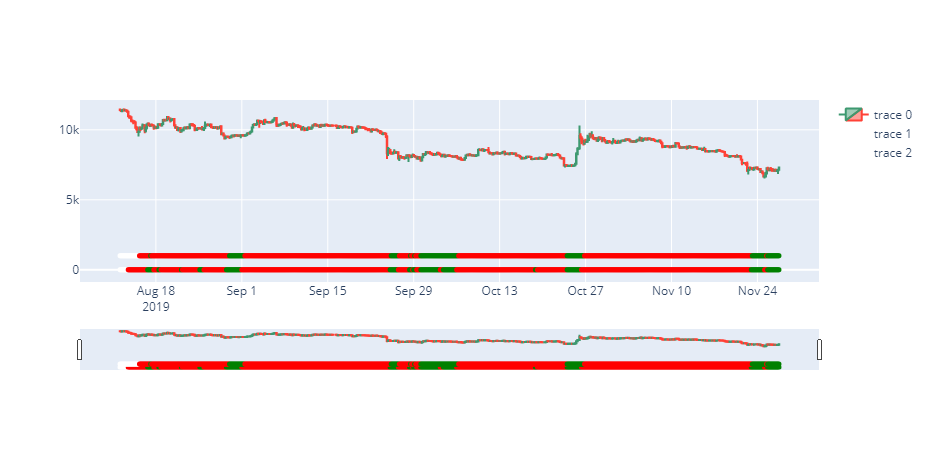

In [68]:
fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig.add_trace(go.Scatter(x=df['date'], y=[0]*len(df['date']), mode='markers',
                         marker=dict(size=5, color=get_ema(9))))
fig.add_trace(go.Scatter(x=df['date'], y=[1000]*len(df['date']), mode='markers',
                         marker=dict(size=5, color=get_ema(20))))

fig.show()

In [61]:
def logic(account, lookback):
    try:
        lookback = df
        # Load into period class to simplify indexing
        lookback = helpers.period(lookback)
        
        now = lookback.loc(0) # Current candle
        previous = lookback.loc(-1) # Previous candle
        
        if now['EMA'] < 0:
            risk          = 0.03
            entry_price   = now['close']
            entry_capital = account.buying_power*risk
            account.enter_position('long', entry_capital, entry_price)
        elif now['EMA'] > 0:
            risk          = 0.03
            entry_price   = now['close']
            entry_capital = account.buying_power*risk
            account.close_position('short', entry_capital, entry_price)
     
    except ValueError: 
        pass # Handles lookback errors in beginning of dataset

In [74]:
def automated_backtest(ema_start=1, ema_end=2, iter_list=None):
    """ema_start (int) : Lower bound for the range of the Number of MA days to consider
        ema_end (int) : Upper bound for the range of the Number of MA days to consider
    """
    if not iter_list:
        iter_list = [num for i in range(ema_start, ema_end+1)]
    days = len(iter_list)
    net_profit_df = pd.DataFrame({'ema_day':iter_list,'net_profit':[None]*days})

    for idx, i in enumerate(iter_list):
        df['EMA'] = df['fundingRate'].ewm(span=i, min_periods=i).mean()
        backtest = engine.backtest(df)
        # Start backtesting custom logic with 1000 (BTC) intital capital
        backtest.start(100000, logic)
        being_price = backtest.data.iloc[0]['open']
        final_price = backtest.data.iloc[-1]['close']
        pc = helpers.percent_change(being_price, final_price)
        net_profit_df['net_profit'].iloc[idx] = round(helpers.profit(backtest.account.initial_capital, pc), 2)
    return net_profit_df

In [75]:
automated_backtest(iter_list=[8,9,25])

,ema_day,net_profit
0,8,-36179.46000000
1,9,-36179.46000000
2,25,-36179.46000000


In [16]:
backtest.results()
backtest.chart()

C:\Users\laide\Miniconda3\envs\venture_256\lib\site-packages\bokeh\util\deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

C:\Users\laide\Miniconda3\envs\venture_256\lib\site-packages\bokeh\util\deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead



In [62]:
backtest.chart()

C:\Users\laide\Miniconda3\envs\venture_256\lib\site-packages\bokeh\util\deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

C:\Users\laide\Miniconda3\envs\venture_256\lib\site-packages\bokeh\util\deprecation.py:68: BokehDeprecationWarning:

'legend' keyword is deprecated, use explicit 'legend_label', 'legend_field', or 'legend_group' keywords instead

